In [568]:
import numpy as np
import pandas as pd
import os
import sys
import xgboost as xgb
import matplotlib.pyplot as plt
import datetime as dt
import missingno as msno
import seaborn as sns
import sklearn
from scipy import stats
%matplotlib inline
state = 32
np.random.seed(state)
print ('numpy version:', np.__version__, 'pandas version:', pd.__version__)

numpy version: 1.21.5 pandas version: 1.3.4


### READ DATA

In [223]:
df = pd.read_excel('vesselData.xlsx')
df

,eta,ata,atd,vesseldwt,vesseltype,discharge1,load1,discharge2,load2,discharge3,...,load4,stevedorenames,hasnohamis,earliesteta,latesteta,traveltype,previousportid,nextportid,isremarkable,vesselid
0,2017-09-19 00:00:00+00,2017-09-19 00:00:00+00,2017-09-22 00:00:00+00,109290.0,5.0,0.0,0.0,0.0,0.0,90173.0,...,0.0,Stevedore_104,NaN,2017-09-19 00:00:00+00,2017-09-19 00:00:00+00,ARRIVAL,981.0,731.0,f,2242.0
1,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,2017-10-03 00:00:00+00,67170.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_109,NaN,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,ARRIVAL,19.0,15.0,f,5462.0
2,2017-09-30 00:00:00+00,2017-09-30 00:00:00+00,2017-10-01 00:00:00+00,67737.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_57,NaN,2017-09-30 00:00:00+00,2017-09-30 00:00:00+00,ARRIVAL,19.0,19.0,f,5251.0
3,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,2017-10-03 00:00:00+00,43600.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_57,NaN,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,ARRIVAL,15.0,18.0,f,5268.0
4,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,9231.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_98,NaN,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,ARRIVAL,74.0,27.0,f,5504.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8203,2017-11-03 00:00:00+00,2017-11-03 00:00:00+00,2017-11-04 00:00:00+00,9587.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_64,NaN,2017-11-02 00:00:00+00,2017-11-03 00:00:00+00,ARRIVAL,5.0,19.0,f,5681.0
8204,2017-11-04 00:00:00+00,2017-11-04 00:00:00+00,2017-11-06 00:00:00+00,9654.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,"Stevedore_110,Stevedore_57,Stevedore_99,Steved...",NaN,2017-11-04 00:00:00+00,2017-11-05 00:00:00+00,SHIFT,391.0,102.0,f,4843.0
8205,2017-11-08 00:00:00+00,2017-11-07 00:00:00+00,2017-11-11 00:00:00+00,4726.0,5.0,0.0,0.0,0.0,0.0,0.0,...,3051.0,"Stevedore_89,Stevedore_79,Stevedore_75,Stevedo...",NaN,2017-11-07 00:00:00+00,2017-11-10 00:00:00+00,SHIFT,1043.0,19.0,f,3115.0
8206,2017-11-10 00:00:00+00,2017-11-10 00:00:00+00,2017-11-10 00:00:00+00,13320.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_46,NaN,2017-11-10 00:00:00+00,2017-11-10 00:00:00+00,ARRIVAL,54.0,71.0,f,4623.0


In [224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8208 entries, 0 to 8207
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   eta             8208 non-null   object 
 1   ata             8208 non-null   object 
 2   atd             8208 non-null   object 
 3   vesseldwt       8206 non-null   float64
 4   vesseltype      8208 non-null   float64
 5   discharge1      8208 non-null   float64
 6   load1           8208 non-null   float64
 7   discharge2      8208 non-null   float64
 8   load2           8208 non-null   float64
 9   discharge3      8208 non-null   float64
 10  load3           8208 non-null   float64
 11  discharge4      8208 non-null   float64
 12  load4           8208 non-null   float64
 13  stevedorenames  8206 non-null   object 
 14  hasnohamis      0 non-null      float64
 15  earliesteta     8208 non-null   object 
 16  latesteta       8208 non-null   object 
 17  traveltype      8208 non-null   o

### INVESTIGATE TARGET VARIABLES

In [225]:
targets_df = df[['load1', 'discharge1','load2', 'discharge2', 'load3', 'discharge3', 'load4', 'discharge4']]
targets_df

,load1,discharge1,load2,discharge2,load3,discharge3,load4,discharge4
0,0.0,0.0,0.0,0.0,0.0,90173.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
8203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8205,0.0,0.0,0.0,0.0,0.0,0.0,3051.0,3537.0
8206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [226]:
targets_df.describe()

,load1,discharge1,load2,discharge2,load3,discharge3,load4,discharge4
count,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000
mean,60.754386,1732.712841,19.387549,1168.698221,44.745492,4791.331871,1509.046784,1820.782407
std,1325.463945,16297.994648,665.333248,11331.135301,3071.717973,25366.035772,11936.519585,10034.936858
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,41761.000000,204304.000000,43639.000000,189933.000000,271251.000000,299647.000000,293449.000000,183837.000000


In [227]:
for i in range(1,5):
    print (f'load{i}',targets_df.loc[targets_df[f'load{i}'] > 0, f'load{i}'].count())
print('-----')
for i in range(1,5):
    print (f'discharge{i}',targets_df.loc[targets_df[f'discharge{i}'] > 0, f'discharge{i}'].count())

load1 40
load2 21
load3 8
load4 446
-----
discharge1 138
discharge2 112
discharge3 378
discharge4 558


### TARGETS INITIAL INSIGHTS
Cargo type 4 (petrol) is the least type with missing load and discharge data (446 load/ 558 discharge).

Based on a quick search https://bulkcarrierguide.com/cargo.html, I made an assumption: <br>
The handling of ore & coal might be similar (i.e., soild bulk cargo). Likewise oil & petrol (i.e., liquid bulk) might have similar handling routines in terms of safety, regulations, transportation. <br>

Therefore:<br>
Attempting to concatenate load1 + load2 --> load_solid <br>
Attempting to concatenate load3 + load4 --> load_liquid <br>
Attempting to concatenate discharge1 + discharge2 --> discharge_solid <br>
Attempting to concatenate discharge3 + discharge4 --> discharge_liquid <br>

This is to maximize the supervision signal to train our predictive model.

### SOLUTION OVERVIEW: <br>
Train one load model to predict load for both solid and liquid cargo.<br>
Train one discharge model to predict discharge for both solid and liquid cargo<br>

In [228]:
valid_load1 = targets_df.loc[targets_df['load1'] > 0, 'load1']
valid_load2 = targets_df.loc[targets_df['load2'] > 0, 'load2']
load_solid = pd.concat([valid_load1, valid_load2] )

valid_load3 = targets_df.loc[targets_df['load3'] > 0, 'load3']
valid_load4 = targets_df.loc[targets_df['load4'] > 0, 'load4']
load_liquid = pd.concat([valid_load3, valid_load4] )
load_liquid


valid_disc1 = targets_df.loc[targets_df['discharge1'] > 0, 'discharge1']
valid_disc2 = targets_df.loc[targets_df['discharge2'] > 0, 'discharge2']
disc_solid= pd.concat([valid_disc1, valid_disc2] )
disc_solid


valid_disc3 = targets_df.loc[targets_df['discharge3'] > 0, 'discharge3']
valid_disc4 = targets_df.loc[targets_df['discharge4'] > 0, 'discharge4']
disc_liquid= pd.concat([valid_disc3, valid_disc4] )
disc_liquid 


0        90173.0
8        14044.0
27      131231.0
36       99862.0
50      102817.0
          ...   
8131      5104.0
8188     15980.0
8191      4196.0
8194     28127.0
8205      3537.0
Length: 936, dtype: float64

### FEATURES SELECTION & ENGINEERING

1. Dropping common sense non-informative features
2. Engineering a new feature ```n_stevs``` outlining the number of stevedores per ship
3. Construct a ```process_time``` feature as the difference in days from the 2 dates ```atd ``` - ```ata```
4. Construct a binary variable ```bulk_type``` to define the cargo type {'solid': 0, 'liquid': 1}


In [229]:
# 1. Dropping common sense non-informative features
exclusion_set = ['ata', 'atd','eta', 'previousportid', 'nextportid','earliesteta', 'stevedorenames', 'vesselid', 'latesteta', 'hasnohamis']
feature_candidates = ['vesseldwt', 'vesseltype', 'traveltype', 'isremarkable']
feature_df = df[['vesseldwt', 'vesseltype', 'traveltype']]
feature_df

,vesseldwt,vesseltype,traveltype
0,109290.0,5.0,ARRIVAL
1,67170.0,3.0,ARRIVAL
2,67737.0,3.0,ARRIVAL
3,43600.0,3.0,ARRIVAL
4,9231.0,3.0,ARRIVAL
...,...,...,...
8203,9587.0,3.0,ARRIVAL
8204,9654.0,3.0,SHIFT
8205,4726.0,5.0,SHIFT
8206,13320.0,3.0,ARRIVAL


In [230]:
# 2. Engineering a new feature ```n_stevs``` outlining the number of stevedores per ship
df['stevedorenames'] = df['stevedorenames'].astype('str')
feature_df['n_stevs'] = df['stevedorenames'].str.split(',').apply(lambda x : len(x))
feature_df

D:\anaconda3\envs\omdena\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,vesseldwt,vesseltype,traveltype,n_stevs
0,109290.0,5.0,ARRIVAL,1
1,67170.0,3.0,ARRIVAL,1
2,67737.0,3.0,ARRIVAL,1
3,43600.0,3.0,ARRIVAL,1
4,9231.0,3.0,ARRIVAL,1
...,...,...,...,...
8203,9587.0,3.0,ARRIVAL,1
8204,9654.0,3.0,SHIFT,5
8205,4726.0,5.0,SHIFT,4
8206,13320.0,3.0,ARRIVAL,1


In [231]:
# 3. construct process_time feature
ata = pd.to_datetime(df['ata']).dt.date
atd = pd.to_datetime(df['atd']).dt.date
feature_df['process_time'] = (atd - ata).dt.days
feature_df

D:\anaconda3\envs\omdena\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,vesseldwt,vesseltype,traveltype,n_stevs,process_time
0,109290.0,5.0,ARRIVAL,1,3
1,67170.0,3.0,ARRIVAL,1,1
2,67737.0,3.0,ARRIVAL,1,1
3,43600.0,3.0,ARRIVAL,1,1
4,9231.0,3.0,ARRIVAL,1,0
...,...,...,...,...,...
8203,9587.0,3.0,ARRIVAL,1,1
8204,9654.0,3.0,SHIFT,5,2
8205,4726.0,5.0,SHIFT,4,4
8206,13320.0,3.0,ARRIVAL,1,0


In [232]:
# 4. construct the bulk_type feature
disc_liquid = disc_liquid[~ disc_liquid.index.duplicated()]
solid_bulk = pd.concat([load_solid, disc_solid], axis = 1)
solid_bulk.insert(0,'bulk', value ='solid')
liquid_bulk = pd.concat([load_liquid, disc_liquid], axis = 1)
liquid_bulk.insert(0,'bulk',value= 'liquid')

targs = pd.concat([solid_bulk, liquid_bulk], axis= 0)
targs.columns = ['bulk','load', 'discharge']
targs



,bulk,load,discharge
5,solid,NaN,72741.0
23,solid,4188.0,NaN
44,solid,39786.0,NaN
62,solid,NaN,50743.0
88,solid,7005.0,NaN
...,...,...,...
8188,liquid,NaN,15980.0
8191,liquid,4206.0,4196.0
8192,liquid,NaN,139431.0
8194,liquid,NaN,28127.0


In [233]:
feature_df = feature_df.join(targs, how= 'right')
feature_df

,vesseldwt,vesseltype,traveltype,n_stevs,process_time,bulk,load,discharge
0,109290.0,5.0,ARRIVAL,1,3,liquid,NaN,90173.0
5,74518.0,2.0,ARRIVAL,1,2,solid,NaN,72741.0
8,17069.0,5.0,ARRIVAL,1,1,liquid,NaN,14044.0
23,7133.0,3.0,ARRIVAL,1,1,solid,4188.0,NaN
27,158070.0,5.0,ARRIVAL,1,2,liquid,NaN,131231.0
...,...,...,...,...,...,...,...,...
8188,25432.0,5.0,ARRIVAL,1,2,liquid,NaN,15980.0
8191,4993.0,5.0,SHIFT,2,8,liquid,4206.0,4196.0
8192,158583.0,5.0,SHIFT,2,2,liquid,NaN,139431.0
8194,37296.0,5.0,ARRIVAL,1,4,liquid,NaN,28127.0


In [234]:
feature_df.iloc[:,:-2][feature_df.iloc[:,:-2].isna().any(axis = 1)]

,vesseldwt,vesseltype,traveltype,n_stevs,process_time,bulk
581,NaN,5.0,ARRIVAL,1,2,liquid


In [235]:
vess5_medweight = feature_df.vesseldwt.loc [feature_df.vesseltype == 5].median()
feature_df['vesseldwt'] = feature_df['vesseldwt'].fillna(vess5_medweight)
feature_df['vesseldwt']

0       109290.0
5        74518.0
8        17069.0
23        7133.0
27      158070.0
          ...   
8188     25432.0
8191      4993.0
8192    158583.0
8194     37296.0
8205      4726.0
Name: vesseldwt, Length: 1606, dtype: float64

In [236]:
# feature_df[['vesseltype','traveltype','bulk']] = feature_df[['vesseltype','traveltype','bulk']].apply(lambda col: col.astype('category'), axis=1)

In [237]:
feature_df['vesseltype'] = feature_df['vesseltype'].astype('category')
feature_df[['vesseltype','traveltype','bulk']].describe()

,vesseltype,traveltype,bulk
count,1606.0,1606,1606
unique,3.0,2,2
top,5.0,ARRIVAL,liquid
freq,1262.0,1312,1296


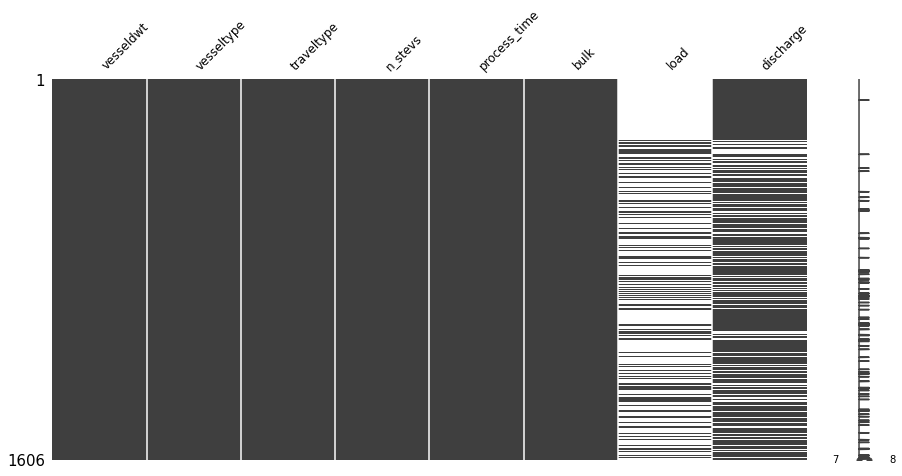

In [238]:
msno.matrix(feature_df.sort_values(by=['vesseltype'], ascending=True), figsize= (15,7), fontsize = 12)
plt.show()

D:\anaconda3\envs\omdena\lib\site-packages\pandas\io\formats\format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


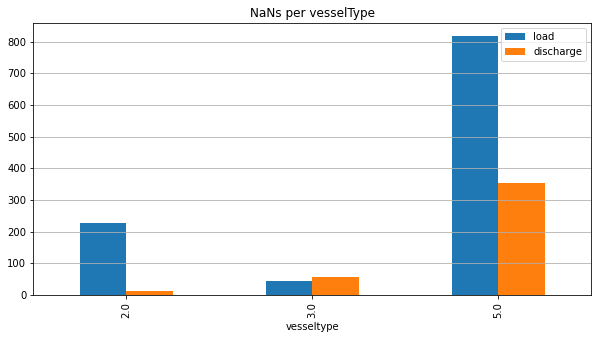

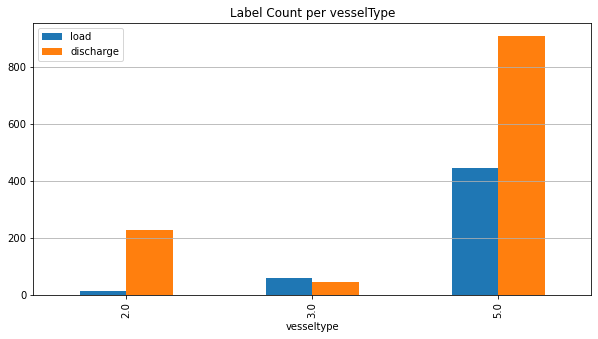

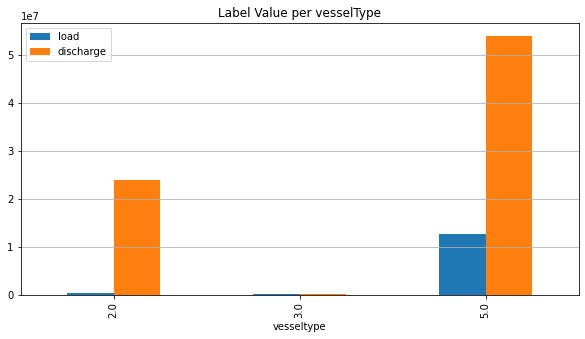

In [239]:
feature_df[['load','discharge']].isna().groupby(by=feature_df['vesseltype']).sum().plot.bar(figsize = (10,5), title = 'NaNs per vesselType')
plt.grid(axis = 'y', linestyle='-')
feature_df[['load','discharge']].groupby(by=feature_df['vesseltype'], dropna= True).count().plot.bar(figsize = (10,5), title = 'Label Count per vesselType')
plt.grid(axis = 'y', linestyle='-')
feature_df[['load','discharge']].groupby(by=feature_df['vesseltype'], dropna= True).sum().plot.bar(figsize = (10,5), title = 'Label Value per vesselType')
plt.grid(axis = 'y', linestyle='-')
plt.show()



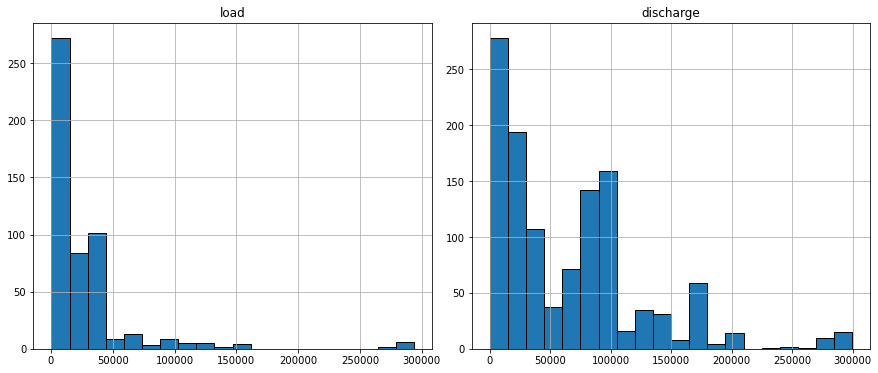

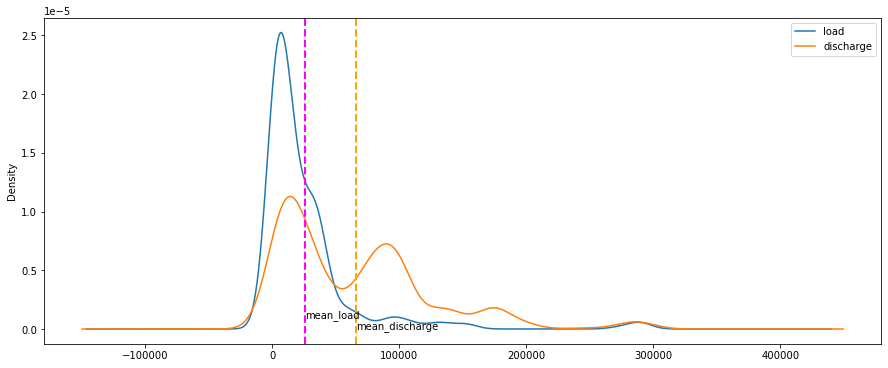

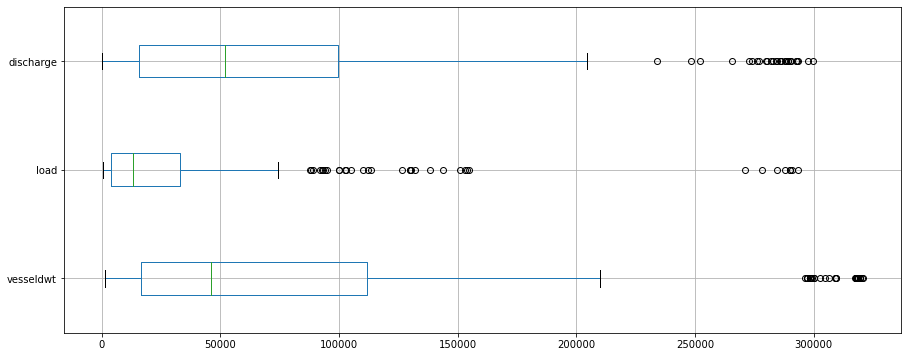

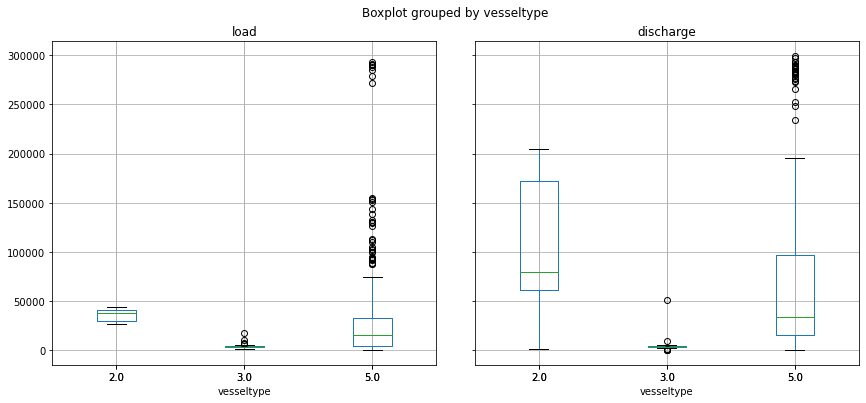

In [240]:
load_mean = feature_df['load'].mean()
discharge_mean = feature_df['discharge'].mean()
feature_df.hist(['load', 'discharge'], bins=20, figsize=(15,6), edgecolor='k')
plt.subplots_adjust(wspace= 0.1)
feature_df[['load','discharge']].plot.density(bw_method = 0.2, figsize = (15,6))
plt.axvline(x=load_mean, color = 'magenta', linestyle='dashed', linewidth = 2)
plt.axvline(x=discharge_mean, color = 'orange', linestyle='dashed', linewidth = 2)
plt.text(load_mean, y= 0.1e-5, s= 'mean_load')
plt.text(discharge_mean, y= 0, s= 'mean_discharge')
plt.subplots_adjust(wspace= 0.0001)
plt.show()
feature_df.boxplot(['vesseldwt','load','discharge'], vert = False, figsize=(15,6))
feature_df.boxplot(['load','discharge'], by='vesseltype', figsize=(14,6))
plt.subplots_adjust(wspace= 0.1)

plt.show()

In [241]:
feature_df.loc[feature_df['load'] >= 250000]

,vesseldwt,vesseltype,traveltype,n_stevs,process_time,bulk,load,discharge
865,302845.0,5.0,SHIFT,2,3,liquid,287721.0,288241.0
1329,297376.0,5.0,ARRIVAL,5,2,liquid,284559.0,280540.0
1369,318513.0,5.0,SHIFT,2,8,liquid,293449.0,284196.0
2718,298330.0,5.0,ARRIVAL,2,2,liquid,289998.0,289310.0
2791,156572.0,5.0,SHIFT,2,36,liquid,271251.0,265727.0
2818,317356.0,5.0,ARRIVAL,1,2,liquid,289971.0,251985.0
5426,318517.0,5.0,SHIFT,2,7,liquid,290977.0,NaN
6770,309164.0,5.0,ARRIVAL,1,3,liquid,278348.0,293409.0


#### FEATURE ENCODING

In [242]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
curated_df = pd.get_dummies(feature_df, columns=['vesseltype','traveltype','bulk'])
curated_df

,vesseldwt,n_stevs,process_time,load,discharge,vesseltype_2.0,vesseltype_3.0,vesseltype_5.0,traveltype_ARRIVAL,traveltype_SHIFT,bulk_liquid,bulk_solid
0,109290.0,1,3,NaN,90173.0,0,0,1,1,0,1,0
5,74518.0,1,2,NaN,72741.0,1,0,0,1,0,0,1
8,17069.0,1,1,NaN,14044.0,0,0,1,1,0,1,0
23,7133.0,1,1,4188.0,NaN,0,1,0,1,0,0,1
27,158070.0,1,2,NaN,131231.0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8188,25432.0,1,2,NaN,15980.0,0,0,1,1,0,1,0
8191,4993.0,2,8,4206.0,4196.0,0,0,1,0,1,1,0
8192,158583.0,2,2,NaN,139431.0,0,0,1,0,1,1,0
8194,37296.0,1,4,NaN,28127.0,0,0,1,1,0,1,0


In [243]:
load_dataset = curated_df.dropna(subset=['load']).drop('discharge', axis= 1)
discharge_dataset = curated_df.dropna(subset=['discharge']).drop('load', axis= 1)
discharge_dataset

,vesseldwt,n_stevs,process_time,discharge,vesseltype_2.0,vesseltype_3.0,vesseltype_5.0,traveltype_ARRIVAL,traveltype_SHIFT,bulk_liquid,bulk_solid
0,109290.0,1,3,90173.0,0,0,1,1,0,1,0
5,74518.0,1,2,72741.0,1,0,0,1,0,0,1
8,17069.0,1,1,14044.0,0,0,1,1,0,1,0
27,158070.0,1,2,131231.0,0,0,1,1,0,1,0
36,111775.0,1,4,99862.0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
8188,25432.0,1,2,15980.0,0,0,1,1,0,1,0
8191,4993.0,2,8,4196.0,0,0,1,0,1,1,0
8192,158583.0,2,2,139431.0,0,0,1,0,1,1,0
8194,37296.0,1,4,28127.0,0,0,1,1,0,1,0


# MODELING

In [244]:
from sklearn.model_selection import train_test_split
X = discharge_dataset.drop('discharge', axis= 1)
y = discharge_dataset[['discharge']]
xtrain, xtest, ytrain, ytest = train_test_split(X,y, test_size= 0.2, shuffle= True)
print (xtrain.shape, xtest.shape)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size= 0.25, shuffle= True)
print (xtrain.shape, xval.shape)

(947, 10) (237, 10)
(710, 10) (237, 10)


In [245]:
params = {'objective': 'reg:squarederror' , 'learning_rate': 0.3, 'gamma': 0, 'max_depth': 6, 'missing': 0, 'seed': 32 , 'subsample': 0.5, 'colsample_bytree': 0.5,
'reg_lambda': 0, 'n_estimators': 3000, 'eval_metric': ['mae','rmse']}
model = xgb.XGBRegressor(**params, verbosity = 1, validate_parameters = True)
eval_sets = [ (xtrain, ytrain), (xval, yval)]
# model.get_xgb_params()

In [246]:
model.fit(xtrain, ytrain, eval_set= eval_sets, verbose= True, early_stopping_rounds= 10)

[0]	validation_0-mae:49438.60938	validation_0-rmse:72262.00781	validation_1-mae:51881.85547	validation_1-rmse:77766.13281
[1]	validation_0-mae:43392.16406	validation_0-rmse:62732.17578	validation_1-mae:46964.50781	validation_1-rmse:69173.57812
[2]	validation_0-mae:31954.26172	validation_0-rmse:45776.45703	validation_1-mae:35469.43750	validation_1-rmse:52230.09766
[3]	validation_0-mae:24471.46680	validation_0-rmse:35344.80859	validation_1-mae:27451.76562	validation_1-rmse:41190.62109
[4]	validation_0-mae:23577.98242	validation_0-rmse:33444.87500	validation_1-mae:26314.57227	validation_1-rmse:39073.19141
[5]	validation_0-mae:19515.57812	validation_0-rmse:27278.00977	validation_1-mae:22075.98047	validation_1-rmse:33125.78906
[6]	validation_0-mae:16732.19727	validation_0-rmse:23579.89453	validation_1-mae:19309.49805	validation_1-rmse:29942.55273
[7]	validation_0-mae:16601.10156	validation_0-rmse:23193.14062	validation_1-mae:19051.22852	validation_1-rmse:29419.54492
[8]	validation_0-mae:145

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             eval_metric=['mae', 'rmse'], gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=0, monotone_constraints='()',
             n_estimators=3000, n_jobs=12, num_parallel_tree=1,
             predictor='auto', random_state=32, reg_alpha=0, reg_lambda=0,
             scale_pos_weight=1, seed=32, subsample=0.5, tree_method='exact',
             validate_parameters=True, verbosity=1)

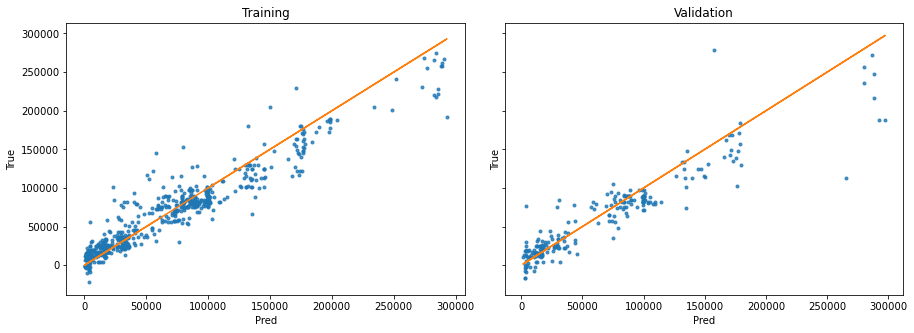

In [247]:
train_pred = model.predict(xtrain)
val_pred = model.predict(xval)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (15,5), sharey = True)
sns.regplot(x = ytrain, y = train_pred, fit_reg= False, marker = '.', ax = ax0)
sns.regplot(x = yval, y = val_pred, fit_reg= False, marker = '.', ax = ax1)
ax0.plot(ytrain, ytrain, '-')
ax0.set_xlabel('Pred')
ax0.set_ylabel('True')
ax0.set_title('Training')

ax1.plot(yval, yval, '-')
ax1.set_xlabel('Pred')
ax1.set_ylabel('True')
ax1.set_title('Validation')
plt.subplots_adjust(wspace=0.1)
plt.show()

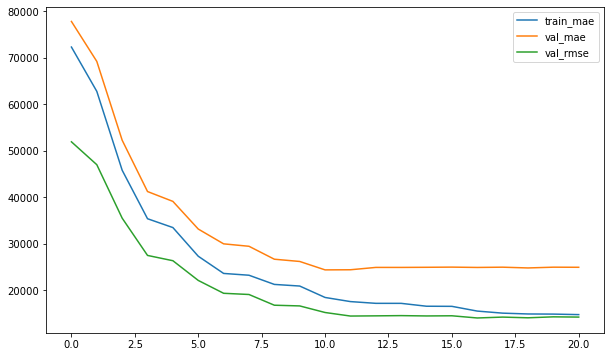

In [248]:
train_scores = pd.DataFrame(model.evals_result_['validation_0'])
val_scores = pd.DataFrame(model.evals_result_['validation_1'])
scores = pd.concat([train_scores, val_scores],axis= 1)
scores.columns = ['train_rmse', 'train_mae', 'val_rmse', 'val_mae']
scores[['train_mae', 'val_mae', 'val_rmse']].plot(figsize = (10,6))
# scores.plot(figsize = (10,6))
plt.show()

# SMOGN

In [491]:
import smogn
import pandas
import seaborn

traindata = pd.concat([xtrain, ytrain],axis= 1).reset_index()
train_balanced = smogn.smoter(data= traindata, y= 'discharge')
simple = train_balanced.reset_index()

IndexError: positional indexers are out-of-bounds

In [433]:
traindata = pd.concat([xtrain, ytrain],axis= 1).reset_index()
train_balanced_adv = smogn.smoter(data= traindata, y='discharge',
                                k = 10,
                                pert = 0.04,
                                samp_method = 'extreme',
                                drop_na_col = False,
                                drop_na_row = False,
                                replace = True,
                                rel_thres = .45,
                                rel_method = 'auto',
                                rel_xtrm_type = 'both',
                                rel_coef = 1.5
                                )
adv = train_balanced_adv.reset_index()

synth_matrix: 100%|##########| 101/101 [00:01<00:00, 91.66it/s]


<AxesSubplot:xlabel='discharge', ylabel='Density'>

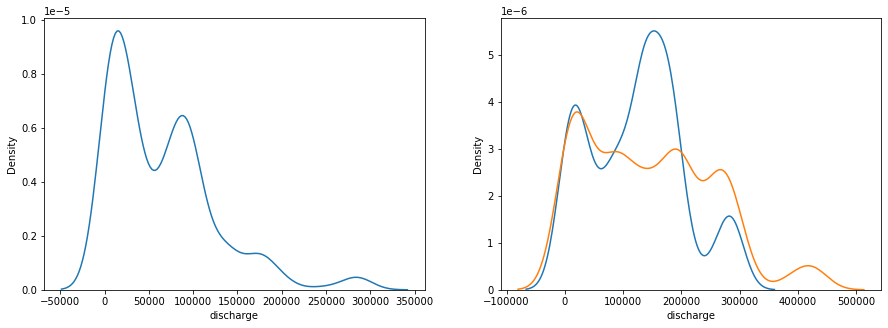

In [434]:
traindata = pd.concat([xtrain, ytrain],axis= 1).reset_index()

fig, ax = plt.subplots(1,2, figsize = (15,5))
sns.kdeplot(traindata.discharge, ax = ax[0])
sns.kdeplot(simple.discharge, ax = ax[1])
sns.kdeplot(adv.discharge, ax = ax[1])


In [461]:
xtrain_smg = train_balanced_adv.iloc[:,:-1]
ytrain_smg = train_balanced_adv[['discharge']]

# LDS --> KERNEL SMOOTHING

What you should have done is first split the data into train and test and then perform all the usampling on the train and create a model and then test it on test data. You don't touch or modify the test data. 

This way you can actually prevent the data leakage. Now because you have upsampled first and then split, obviously your model would be better for every class. But I dont think it is a true generalized representation. You can use stratified splitting before splitting the data to represent all the class labels.

In [1]:
from  importlib import reload
import utils
reload(utils)
from utils import *
lds = LDS(labels= ytrain.discharge, buffer= 10000)

NameError: name 'ytrain' is not defined

#### Weights for ytrain.Discharge

In [250]:
bin_df = lds.bin_dataframe(ytrain)
x_wts_df = lds.weight_df(bin_df, weight= 'inverse')
x_wts_df

,discharge,bin,inverse
706,99814.0,100000,0.498285
1356,99983.0,100000,0.498285
4763,80248.0,81000,1.011669
4804,52135.0,53000,1.517503
5883,140829.0,141000,1.517503
...,...,...,...
2845,133494.0,134000,1.517503
4744,99969.0,100000,0.498285
1941,79791.0,80000,0.981914
6613,13598.0,14000,0.490957


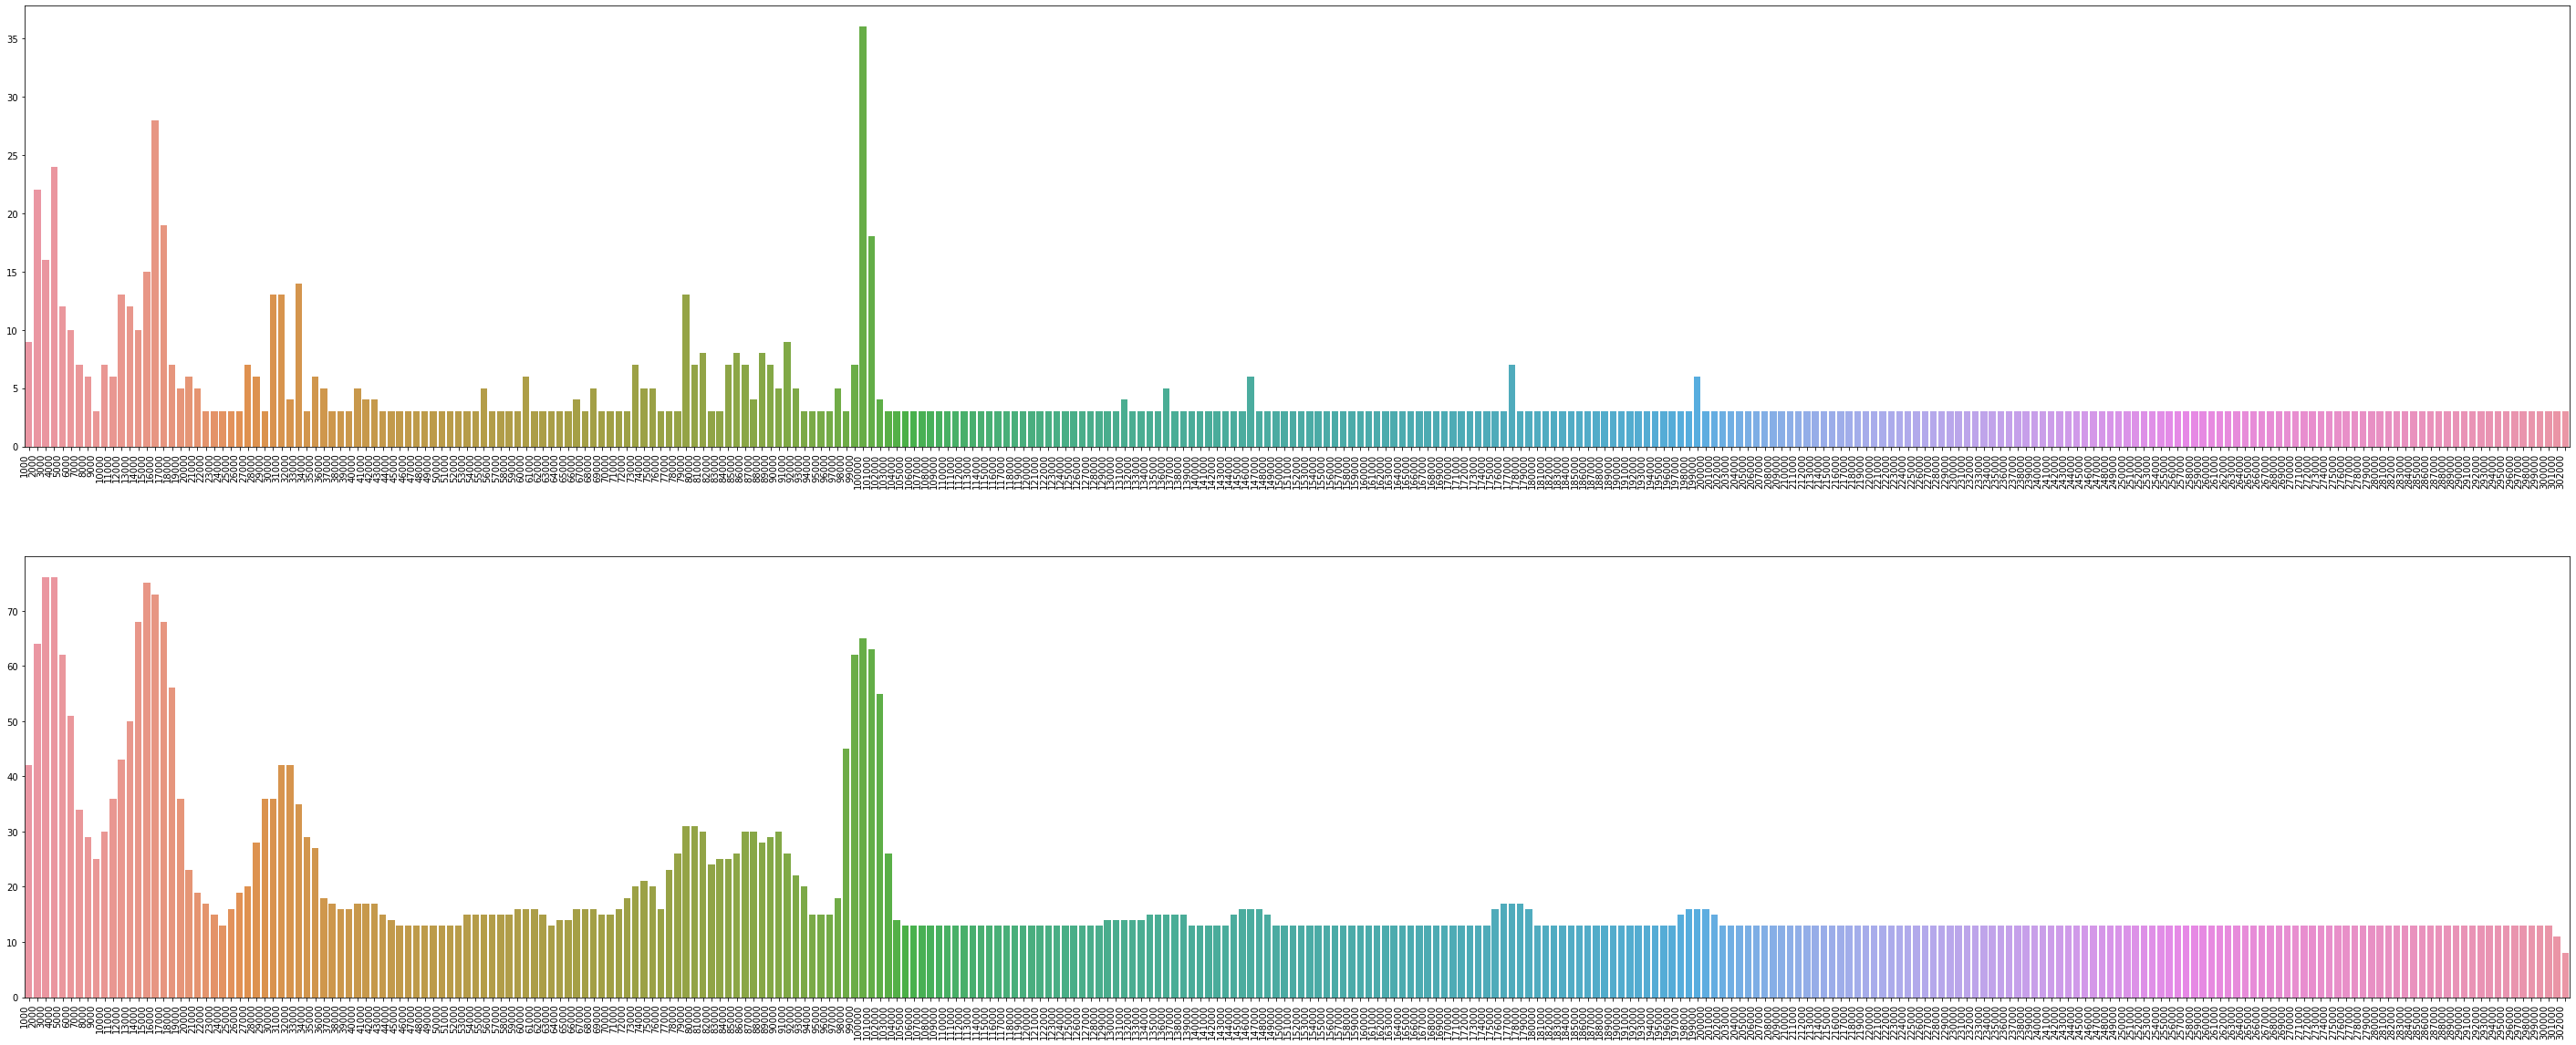

In [251]:
smoothed, emp = lds.effective_dist(smooth= 3)
bins, freqs = zip(*emp.items())
fig, (ax0, ax1) = plt.subplots(2,1, figsize= (50,20), )
sns.barplot(x= list(bins), y= list(freqs), ax =ax0)
ax0.set_xticklabels(ax0.get_xticklabels(), rotation=90, ha='right')

bins, freqs = zip(*smoothed.items())
sns.barplot(x= list(bins), y= list(freqs), ax = ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha='right')
plt.subplots_adjust(hspace= .25)
plt.show()

In [356]:
wts = x_wts_df['inverse']
wts.shape
dtrain_wts = xgb.DMatrix(xtrain, label = ytrain, weight = wts)
deval_wts = xgb.DMatrix(xval, label = yval, weight = wts)
# xtrain_wts.get_weight()

In [357]:
from  importlib import reload
import utils
reload(utils)
from utils import *

In [358]:
loss = weightloss(weights= wts)
params2 = {'objective': loss.weighted_mse ,
 'learning_rate': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'missing': 0,
 'seed': 32,
 'subsample': 0.5,
 'colsample_bytree': 0.5,
 'reg_lambda': 0,
 'n_estimators': 3000,
 'eval_metric': ['mae', 'rmse']}

model_wts = xgb.XGBRegressor(**params2)

### Training the best model with LDS

In [22]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV,ShuffleSplit, PredefinedSplit, LeaveOneOut, cross_val_score, cross_val_predict, KFold, GroupKFold, HalvingRandomSearchCV, RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error, median_absolute_error
from scipy.stats import t

#### A VERY SIMPLE SEARCH: 10 cand; 1 repeat

In [626]:
X_cv = pd.concat([xtrain, xval], axis= 0)
y_cv = pd.concat([ytrain, yval], axis= 0)
model_cv = xgb.XGBRegressor(**params, verbosity = 1, validate_parameters = True)
rpt_cv = RepeatedKFold(n_splits=4, n_repeats= 1, random_state= state)
splts = list (rpt_cv.split(X_cv, y_cv) )
len(splts) # 4 x 10 = 40
print(len(splts[0]) , len(splts[0][0]), len(splts[0][1])) # train/test splits of Itr 0, len_trainSplit, len_testSplit (2, 710, 237)



2 710 237


#### SEARCH SPACE

In [627]:
#### SEARCH DISTs
gamma_dist = stats.betaprime(a = 2,b =6, scale = 10)
sample = gamma_dist.rvs(size= 1000)
print( min(sample), max(sample) )


lambda_dist = stats.expon(scale = 3)
sample = lambda_dist.rvs(size= 1000)
print( min(sample), max(sample) )


lr_dist = stats.loguniform(.0001, .5)
sample = lr_dist.rvs(size= 1000)
print (min(sample), max(sample))

maxchild_dist = stats.nbinom(2, .4, loc = 1)
sample = maxchild_dist.rvs(size= 1000)
print (min(sample), max(sample))

colrow_dist = stats.beta(2.5,1)
sample = colrow_dist.rvs(size= 1000)
print (min(sample), max(sample))

treedepth_dist = stats.nbinom(20, .5)
sample = treedepth_dist.rvs(size= 1000)
print (min(sample), max(sample))


0.13940141874105227 26.98176556228838
0.0015444850752648993 22.96415829670859
0.0001014226264797534 0.49901750153258473
1 15
0.07455159271078546 0.9998135396419565
5 44


In [628]:
search_space = {'learning_rate':lr_dist,
                'max_depth':treedepth_dist,
                'subsample': colrow_dist,
                'colsample_bytree': colrow_dist,
                'reg_lambda': lambda_dist,
                'min_child_weight': maxchild_dist,
                'gamma': gamma_dist}

successhv_cv = HalvingRandomSearchCV(model_cv, cv = rpt_cv, param_distributions= search_space, 
                                    n_candidates= 10, min_resources= 'exhaust', factor= 2,
                                    resource= 'n_samples', verbose= 5, n_jobs= -1, 
                                    scoring= 'neg_median_absolute_error', random_state= state) 

In [363]:
successhv_results = successhv_cv.fit(X_cv, y_cv)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 118
max_resources_: 947
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 10
n_resources: 118
Fitting 4 folds for each of 10 candidates, totalling 40 fits
----------
iter: 1
n_candidates: 5
n_resources: 236
Fitting 4 folds for each of 5 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 3
n_resources: 472
Fitting 4 folds for each of 3 candidates, totalling 12 fits
----------
iter: 3
n_candidates: 2
n_resources: 944
Fitting 4 folds for each of 2 candidates, totalling 8 fits


In [364]:
succhv_results_df = pd.DataFrame(successhv_cv.cv_results_).sort_values('rank_test_score')
succhv_results_df = succhv_results_df.loc[:,~succhv_results_df.columns.str.contains(r"time|param|train")]
succhv_testscores = succhv_results_df.filter(regex= r'test_score|resources')
succhv_testscores
# succhv_results_df[succhv_results_df.eval('n_resources > 900')]

,n_resources,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
19,944,-5858.000000,-5259.927734,-5967.640625,-6839.392578,-5981.240234,563.934897,1
18,944,-5462.084229,-6195.944336,-6397.929688,-6840.781250,-6224.184875,497.989275,2
16,472,-9514.084961,-6427.360352,-7424.703125,-7158.593750,-7631.185547,1146.787175,3
15,472,-10382.415039,-6298.007812,-6824.992188,-7768.414062,-7818.457275,1571.235436,4
13,236,-7338.527344,-7450.328125,-9158.906250,-9134.810547,-8270.643066,877.147827,5
9,118,-11319.718750,-9866.546875,-5236.785156,-6966.268555,-8347.329834,2383.586307,6
17,472,-9807.296875,-7802.258057,-8936.703125,-6983.289062,-8382.386780,1076.064490,7
2,118,-11182.923828,-9237.472656,-5971.908203,-7285.820312,-8419.531250,1973.672070,8
12,236,-6382.001953,-8646.294922,-10605.046875,-8510.066406,-8535.852539,1494.448058,9
1,118,-6625.697266,-13270.875000,-7540.645508,-7610.773438,-8761.997803,2632.051127,10


In [365]:
import joblib
simple_model = successhv_results.best_estimator_
joblib.dump(simple_model,'./models/bestm_simplesearch.pkl', compress= 1 )

['./models/bestm_simplesearch.pkl']

### Weighted training

In [108]:
import joblib
from  importlib import reload
import utils
reload(utils)
from utils import *
simple_model = joblib.load('./models/bestm_simplesearch.pkl')

In [492]:
X_cv_smg = pd.concat([xtrain_smg, xval], axis= 0)
y_cv_smg = pd.concat([ytrain_smg, yval], axis= 0)

In [493]:
lds = LDS(labels = y_cv_smg.discharge, maxbin= 500000)
bin_y_cv = lds.bin_dataframe(y_cv_smg)
wts_cv = lds.weight_df(bin_y_cv, weight= 'inverse').inverse
wts_cv

0       1.446820
1       1.509725
2       1.509725
3       1.509725
4       1.509725
          ...   
7511    0.938478
755     0.428687
1349    1.052233
2796    0.964547
690     0.394587
Name: inverse, Length: 1345, dtype: float64

In [546]:
test_rpt = RepeatedKFold(n_splits=4, n_repeats= 1, random_state= state)
rpt_splits = list(test_rpt.split(X_cv, y_cv))
print (len(rpt_splits))
print (len(rpt_splits[0]), rpt_splits[0][0].shape, rpt_splits[0][1].shape)
print (len(rpt_splits[1]), rpt_splits[1][0].shape, rpt_splits[1][1].shape)
print (len(rpt_splits[-1]), rpt_splits[-1][0].shape, rpt_splits[-1][1].shape)
splt_segment = rpt_splits[0][1]
y_cv.iloc[splt_segment]

4
2 (710,) (237,)
2 (710,) (237,)
2 (711,) (236,)


,discharge
6662,67403.0
5751,103895.0
5952,450.0
5815,22895.0
2264,90949.0
...,...
605,3525.0
7881,62934.0
8108,3548.0
755,2100.0


In [58]:
def metric(pred, label):
    ytrue = label.get_label()
    error = median_absolute_error(ytrue, pred)
    return error

In [631]:
simple_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.7847928149344324,
 'enable_categorical': False,
 'gamma': 2.268433132932169,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.03134676177117836,
 'max_delta_step': 0,
 'max_depth': 22,
 'min_child_weight': 17,
 'missing': 0,
 'monotone_constraints': '()',
 'n_estimators': 3000,
 'n_jobs': 12,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 32,
 'reg_alpha': 0,
 'reg_lambda': 3.9048155205748856,
 'scale_pos_weight': 1,
 'subsample': 0.9776127927297855,
 'tree_method': 'exact',
 'validate_parameters': True,
 'verbosity': 1,
 'seed': 32,
 'eval_metric': ['mae', 'rmse']}

In [548]:
from sklearn.metrics import median_absolute_error
splt_params = simple_model.get_params()
scores = np.zeros(len(rpt_splits))

for n_splt, splt in enumerate(rpt_splits):
    train_idxs, val_idxs = splt
    splt_xtrn, splt_ytrn = X_cv.iloc[train_idxs] , y_cv.iloc[train_idxs]
    splt_xval, splt_yval = X_cv.iloc[val_idxs] , y_cv.iloc[val_idxs]

    lds= LDS(labels= splt_ytrn.discharge, maxbin= 310000)
    binned = lds.bin_dataframe(splt_ytrn)
    x_wts =lds.weight_df(binned).inverse
    objective = weightloss(weights= x_wts)
    splt_params['objective'] = objective.weighted_mse
    i_model = xgb.XGBRegressor(**splt_params)
    i_model = i_model.fit(splt_xtrn, splt_ytrn, verbose= False, eval_set= [(splt_xval, splt_yval)], eval_metric= 'mae')

    valpred = i_model.predict(splt_xval)
    scores[n_splt] = median_absolute_error(splt_yval, valpred )


    # print (n_splt, rpt_splits[n_splt][0].shape, rpt_splits[n_splt][1].shape)
    
scores.mean(), scores.std()
# (5773.4425048828125, 350.7674839454257) Vanilla simple
# (6198.5751953125, 254.19320976760994) simple + LDS
# (6992.47119140625, 913.2490096708192) simple + SMOGN



(6198.5751953125, 254.19320976760994)

In [ ]:
def apply_smogn (xsplit, ysplit, target_col = 'discharge'):

    train_df= pd.concat([xsplit, ysplit],axis= 1).reset_index(drop= True)
    df_smg = smogn.smoter(data= train_df, y= target_col,
                                    k = 8,
                                    pert = 0.04,
                                    samp_method = 'extreme',
                                    drop_na_col = False,
                                    drop_na_row = False,
                                    replace = True,
                                    rel_thres = .45,
                                    rel_method = 'auto',
                                    rel_xtrm_type = 'both',
                                    rel_coef = 1.5
                                    )
        
    x_smg = df_smg.iloc[:,:-1]
    y_smg = df_smg[[target_col]]

    return x_smg, y_smg
x_smg, y_smg = apply_smogn(xtrain, ytrain)

In [623]:
from sklearn.metrics import median_absolute_error

def score_pipline(X_cv, y_cv, cv_object, model ):

    splt_params = model.get_params()
    splits = list(cv_object.split(X_cv, y_cv))
    scores = np.zeros(len(list(splits)))

    for n_splt, splt in enumerate(splits):
        train_idxs, val_idxs = splt
        splt_xtrn, splt_ytrn = X_cv.iloc[train_idxs] , y_cv.iloc[train_idxs]
        splt_xval, splt_yval = X_cv.iloc[val_idxs] , y_cv.iloc[val_idxs]

        splt_xtrn, splt_ytrn = apply_smogn(splt_xtrn, splt_ytrn)

        lds= LDS(labels= splt_ytrn.discharge, buffer= 10000)
        binned = lds.bin_dataframe(splt_ytrn)
        x_wts =lds.weight_df(binned).inverse * 3
        objective = weightloss(weights= x_wts)
        splt_params['objective'] = objective.weighted_mse

        i_model = xgb.XGBRegressor(**splt_params)
        i_model = i_model.fit(splt_xtrn, splt_ytrn, verbose= False, eval_set= [(splt_xval, splt_yval)], eval_metric= 'mae')

        valpred = i_model.predict(splt_xval)
        scores[n_splt] = median_absolute_error(splt_yval, valpred )

    return scores

    # print (n_splt, rpt_splits[n_splt][0].shape, rpt_splits[n_splt][1].shape)
    
scores.mean(), scores.std()

(6216.8604736328125, 819.1174757123306)

In [624]:
scores = score_pipline (X_cv, y_cv, test_rpt, simple_model) #5359.42919921875, 262.400887306297
scores.mean(), scores.std()

r_index: 100%|##########| 19/19 [00:00<00:00, 508.96it/s]


ValueError: oops! synthetic data contains missing values

In [592]:
non_wts_scores = cross_val_score(simple_model, cv = rpt_cv, X = X_cv, y= y_cv, scoring= 'neg_median_absolute_error' )
non_wts_scores.mean(), non_wts_scores.std()

(-5773.4425048828125, 350.7674839454257)

In [ ]:
# wtd_errs = rpt_cv = RepeatedKFold(n_splits=4, n_repeats= 1, random_state= state)
wtd_errs = cross_val_score (estimator= simple_model, X= X_cv, y= y_cv, cv= rpt_cv,)